<a href="https://colab.research.google.com/github/BMateusSs/Projeto-PISI3/blob/main/exploratory_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Install dependencies as needed:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "winemag-data-130k-v2.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "zynicide/wine-reviews",
  file_path
)

<ipython-input-6-7195d7428f2b>:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


ValueError: Error reading file: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

Limpeza dos dados

In [25]:
import pandas as pd

df = df.dropna(subset=["region_1"])
df = df[["region_1", "description"]]
df.head()
# 1. Identificar as 10 regiões com mais registros
top_10_regions = df['region_1'].value_counts().nlargest(10).index.tolist()

# 2. Filtrar o DataFrame para incluir apenas as top 10 regiões
df_top_10 = df[df['region_1'].isin(top_10_regions)]

# 3. Identificar a contagem mínima entre as top 10 regiões
min_count = df_top_10['region_1'].value_counts().min()

print(f"As 10 regiões com mais registros são: {top_10_regions}")
print(f"A contagem mínima de registros entre as top 10 regiões é: {min_count}")

# 4. Amostrar cada uma das top 10 regiões para ter a contagem mínima
sampled_dfs = []
for region in top_10_regions:
    df_region = df_top_10[df_top_10['region_1'] == region]
    # Amostra aleatoriamente 'min_count' registros para cada região
    df_sampled = df_region.sample(n=min_count, random_state=42) # random_state para reprodutibilidade
    sampled_dfs.append(df_sampled)

# Concatenar os DataFrames amostrados de volta em um único DataFrame
df_balanced = pd.concat(sampled_dfs)

# Opcional: Embaralhar as linhas do DataFrame resultante
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Mostrar as primeiras linhas do DataFrame balanceado
print("\nPrimeiras linhas do DataFrame balanceado:")

# Verificar a contagem de registros por região no DataFrame balanceado
print("\nContagem de registros por região no DataFrame balanceado:")
print(df_balanced['region_1'].value_counts())
df_balanced.head()
df = df_balanced

As 10 regiões com mais registros são: ['Napa Valley', 'Columbia Valley (WA)', 'Russian River Valley', 'California', 'Paso Robles', 'Mendoza', 'Willamette Valley', 'Alsace', 'Champagne', 'Barolo']
A contagem mínima de registros entre as top 10 regiões é: 1599

Primeiras linhas do DataFrame balanceado:

Contagem de registros por região no DataFrame balanceado:
region_1
Barolo                  1599
Napa Valley             1599
Columbia Valley (WA)    1599
Paso Robles             1599
California              1599
Mendoza                 1599
Champagne               1599
Alsace                  1599
Willamette Valley       1599
Russian River Valley    1599
Name: count, dtype: int64


In [26]:
import nltk
from nltk.corpus import stopwords
import string

# Baixe as stopwords se ainda não as tiver
try:
    stopwords.words('portuguese')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('portuguese'))

def clean_text(text):
    # Converter para lowercase
    text = text.lower()
    # Remover pontuação
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remover stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Aplicar a função de limpeza na coluna 'description'
df['description'] = df['description'].apply(clean_text)
df.head()

,region_1,description
0,Barolo,enticing aromas of red rose wild red berry and...
1,Barolo,underbrush grilled porcini red berry and grill...
2,Napa Valley,lovely cabernet richly attractive and deeply f...
3,Columbia Valley (WA),this new winery knocks it out of the park with...
4,Paso Robles,this untraditional blend works well with the l...


In [27]:
from sentence_transformers import SentenceTransformer
# Experimente com um modelo diferente, por exemplo:
model = SentenceTransformer('paraphrase-MiniLM-L3-v2')
embeddings = model.encode(df['description'].tolist(), show_progress_bar=True)


Batches:   0%|          | 0/500 [00:00<?, ?it/s]

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
emb_pca = pca.fit_transform(embeddings)

In [30]:
import umap
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_2d = reducer.fit_transform(emb_pca)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [31]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_2d = tsne.fit_transform(embeddings)


<ipython-input-35-89aea60db41b>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_regions)) # Obter um mapa de cores


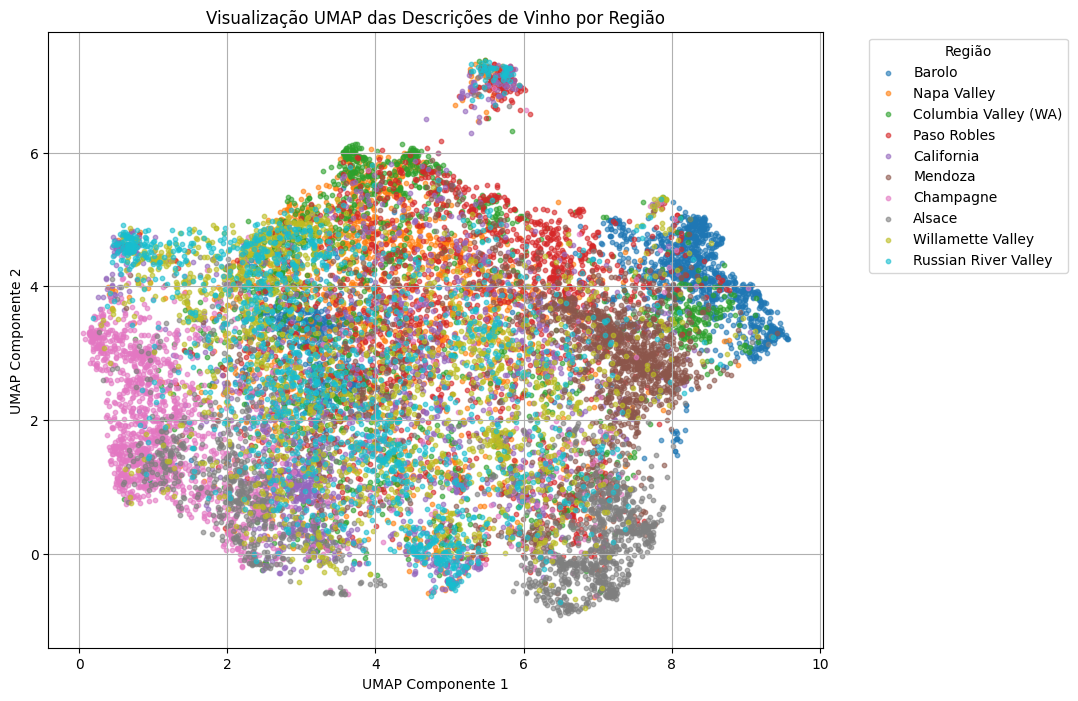

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que você já gerou o 'umap_2d' e tem seu 'df_balanced'
# Certifique-se de que 'umap_2d' e 'df_balanced' estão disponíveis

# Extrair as coordenadas X e Y do umap_2d
x_coords = umap_2d[:, 0]
y_coords = umap_2d[:, 1]

# Opcional: Obter os rótulos das regiões
region_labels = df_balanced['region_1']

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 8)) # Define o tamanho da figura

# Plotar os pontos. Usando a coluna 'region_1' para colorir.
# Para colorir por categoria, você pode iterar sobre as regiões únicas ou usar uma biblioteca como Seaborn
# Uma forma simples com matplotlib é plotar cada região separadamente:
unique_regions = region_labels.unique()
colors = plt.cm.get_cmap('tab10', len(unique_regions)) # Obter um mapa de cores

for i, region in enumerate(unique_regions):
    # Filtrar os dados para a região atual
    mask = region_labels == region
    plt.scatter(
        x_coords[mask],
        y_coords[mask],
        label=region,
        color=colors(i),
        s=10, # Tamanho dos pontos
        alpha=0.6 # Transparência
    )

plt.title('Visualização UMAP das Descrições de Vinho por Região')
plt.xlabel('UMAP Componente 1')
plt.ylabel('UMAP Componente 2')
plt.legend(title='Região', bbox_to_anchor=(1.05, 1), loc='upper left') # Adiciona a legenda fora do gráfico
plt.grid(True)
plt.show() # Mostra o gráfico